<a href="https://colab.research.google.com/github/kassy75035/1st-PyCrawlerMarathon/blob/master/Day085_CB_EarlyStop_%E4%BD%9C%E6%A5%AD_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [9]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
WAITS = [10, 20]

In [10]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
from keras.callbacks import EarlyStopping

for wait in WAITS:
    earlystop = EarlyStopping(monitor="val_accuracy", 
                          patience=wait, 
                          verbose=1
                          )
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Early stop size = %f" % (wait))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)


    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop])
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = (f"Early stop size: {wait}")
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Early stop size = 10.000000
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hidden_layer3 (D

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
49/49 [==============================] - 10s 169ms/step - loss: 2.1859 - accuracy: 0.2736 - val_loss: 2.1178 - val_accuracy: 0.2144
Epoch 2/50
49/49 [==============================] - 8s 163ms/step - loss: 1.7398 - accuracy: 0.3939 - val_loss: 1.9758 - val_accuracy: 0.2944
Epoch 3/50
49/49 [==============================] - 14s 295ms/step - loss: 1.6166 - accuracy: 0.4352 - val_loss: 1.8110 - val_accuracy: 0.3664
Epoch 4/50
49/49 [==============================] - 9s 189ms/step - loss: 1.5430 - accuracy: 0.4605 - val_loss: 1.7183 - val_accuracy: 0.3986
Epoch 5/50
49/49 [==============================] - 10s 199ms/step - loss: 1.4893 - accuracy: 0.4796 - val_loss: 1.6481 - val_accuracy: 0.4223
Epoch 6/50
49/49 [==============================] - 8s 164ms/step - loss: 1.4422 - accuracy: 0.4964 - val_loss: 1.5927 - val_accuracy: 0.4382
Epoch 7/50
49/49 [==============================] - 8s 163ms/step - loss: 1.4016 - accuracy: 0.5120 - val_loss: 1.5446 - val_accuracy: 0.4534
Epo

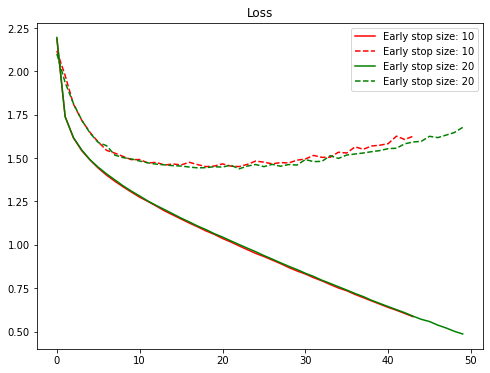

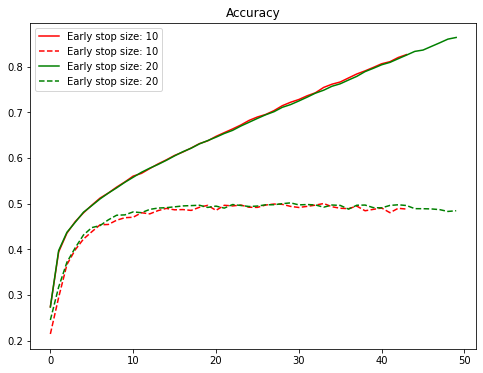

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()